## Gene Regulatory Network (GRN) Analysis

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.pyplot import rc_context
import scanpy as sc
import scipy.io
import os
import math
from pylab import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap 
import seaborn as sns
from pathlib import Path
%matplotlib inline
import loompy as lp

In [1]:
import pyscenic
print(pyscenic.__version__)

0.12.1


In [42]:
sc.settings.set_figure_params(dpi=100, dpi_save=300, figsize=(5, 5))
plt.set_cmap('viridis')
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

<Figure size 500x500 with 0 Axes>

In [10]:
adata=sc.read_h5ad('PlasmaType.h5ad')

In [11]:
tfs_path = "allTFs_hg38.txt"
tfs = [tf.strip() for tf in open(tfs_path)]

In [12]:
loom_path = "input.loom"
loom_path_output = "output.loom"

In [13]:
print(
    f"%{np.sum(adata.var.index.isin(tfs))} out of {len(tfs)} TFs are found in the object"
)

%1098 out of 1797 TFs are found in the object


In [14]:
row_attributes = {
    "Gene": np.array(adata.var.index),
}
col_attributes = {
    "CellID": np.array(adata.obs.index),
    "nGene": np.array(np.sum(adata.X.transpose() > 0, axis=0)).flatten(),
    "nUMI": np.array(np.sum(adata.X.transpose(), axis=0)).flatten(),
}

lp.create(loom_path, adata.X.transpose(), row_attributes, col_attributes)


In [15]:
num_workers = 5

In [16]:
outpath_adj = "adj.csv"
if not os.path.exists(outpath_adj):
    !pyscenic grn {loom_path} {tfs_path} -o $outpath_adj --num_workers {num_workers} 


2024-09-21 02:15:08,036 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2024-09-21 02:15:08,419 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
preparing dask client
parsing input
creating dask graph
5 partitions
computing dask graph
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distribu

In [18]:
results_adjacencies = pd.read_csv("adj.csv", index_col=False, sep=",")
print(f"Number of associations: {results_adjacencies.shape[0]}")
results_adjacencies.head()

Number of associations: 2752970


,TF,target,importance
0,TFF3,ITLN2,107.604500
1,TFF3,SPINK4,104.399758
2,TFF3,ENSSSCG00000040035,96.655483
3,TFF3,REG4,92.237808
4,TFF3,FCN2,89.874688


(-10.0, 10.0)

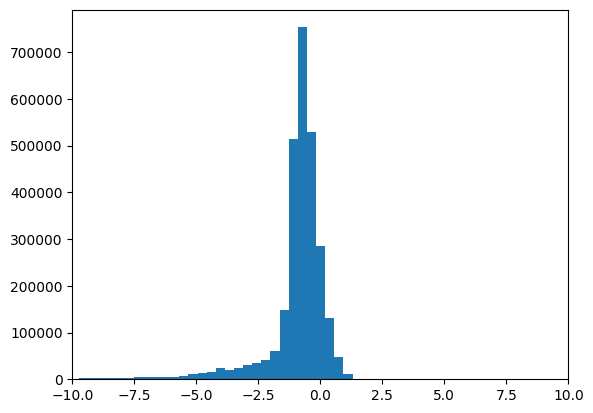

In [19]:
plt.hist(np.log10(results_adjacencies["importance"]), bins=50)
plt.xlim([-10, 10])

In [20]:
!wget -nc https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather

--2024-09-21 05:30:48--  https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather
Resolving resources.aertslab.org (resources.aertslab.org)... 134.58.50.9
Connecting to resources.aertslab.org (resources.aertslab.org)|134.58.50.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1248772066 (1.2G)
Saving to: ‘hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather’

hg38__refseq-r80__1 100%[===================>]   1.16G  5.77MB/s    in 3m 38s  

2024-09-21 05:34:27 (5.46 MB/s) - ‘hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather’ saved [1248772066/1248772066]



In [21]:
db_glob = "*feather" 
db_names = " ".join(glob.glob(db_glob))

In [22]:
!wget -nc https://resources.aertslab.org/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl

--2024-09-21 05:35:45--  https://resources.aertslab.org/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl
Resolving resources.aertslab.org (resources.aertslab.org)... 134.58.50.9
Connecting to resources.aertslab.org (resources.aertslab.org)|134.58.50.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103568514 (99M)
Saving to: ‘motifs-v9-nr.hgnc-m0.001-o0.0.tbl’

motifs-v9-nr.hgnc-m 100%[===================>]  98.77M  8.34MB/s    in 22s     

2024-09-21 05:36:07 (4.58 MB/s) - ‘motifs-v9-nr.hgnc-m0.001-o0.0.tbl’ saved [103568514/103568514]



In [23]:
motif_path = "motifs-v9-nr.hgnc-m0.001-o0.0.tbl"

In [24]:
if not os.path.exists('reg.csv'):
    !pyscenic ctx adj.csv \
        {db_names} \
        --annotations_fname {motif_path} \
        --expression_mtx_fname {loom_path} \
        --output reg.csv \
        --mask_dropouts \
        --num_workers {num_workers} > pyscenic_ctx_stdout.txt


2024-09-21 05:36:12,507 - pyscenic.cli.pyscenic - INFO - Creating modules.

2024-09-21 05:36:13,480 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2024-09-21 05:36:14,104 - pyscenic.utils - INFO - Calculating Pearson correlations.

2024-09-21 05:36:14,561 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2024-09-21 05:36:23,904 - pyscenic.utils - INFO - Creating modules.

2024-09-21 05:38:02,358 - pyscenic.cli.pyscenic - IN

In [26]:
n_genes_detected_per_cell = np.sum(adata.X > 0, axis=1)
percentiles = pd.Series(n_genes_detected_per_cell.flatten().A.flatten()).quantile(
    [0.01, 0.05, 0.10, 0.50, 1]
)
print(percentiles)

0.01     203.0
0.05     217.0
0.10     245.0
0.50     690.0
1.00    7372.0
dtype: float64


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=100)
sns.distplot(n_genes_detected_per_cell, norm_hist=False, kde=False, bins="fd")
for i, x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0, ymax=1, color="red")
    ax.text(
        x=x,
        y=ax.get_ylim()[1],
        s=f"{int(x)} ({percentiles.index.values[i]*100}%)",
        color="red",
        rotation=30,
        size="x-small",
        rotation_mode="anchor",
    )
ax.set_xlabel("# of genes")
ax.set_ylabel("# of cells")
fig.tight_layout()

In [ ]:
if not os.path.exists(loom_path_output):
    !pyscenic aucell $loom_path \
        reg.csv \
        --output {loom_path_output} \
        --num_workers {num_workers} > pyscenic_aucell_stdout.txt

In [29]:
import json
import zlib
import base64

lf = lp.connect(loom_path_output, mode="r+", validate=False)
auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [ ]:
import anndata as ad

ad_auc_mtx = ad.AnnData(auc_mtx)
sc.pp.neighbors(ad_auc_mtx, n_neighbors=10, metric="correlation")
sc.tl.umap(ad_auc_mtx)
sc.tl.tsne(ad_auc_mtx)

In [31]:
adata.obsm["X_umap_aucell"] = ad_auc_mtx.obsm["X_umap"]
adata.obsm["X_tsne_aucell"] = ad_auc_mtx.obsm["X_tsne"]

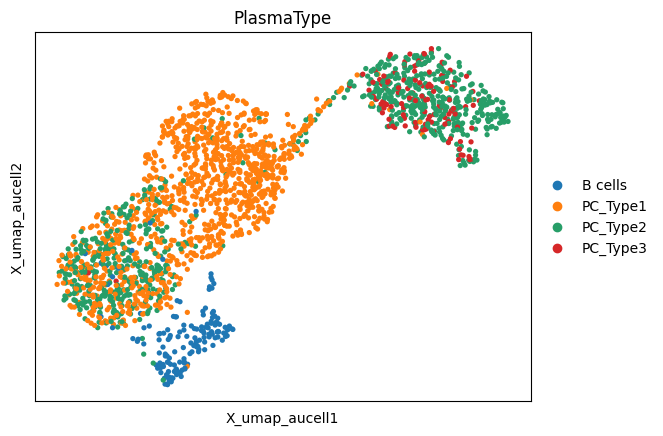

In [32]:
sc.pl.embedding(adata, basis="X_umap_aucell", color="PlasmaType")

### Visualization

In [33]:
import seaborn as sns

In [34]:
auc_mtx["PlasmaType"] = adata.obs["PlasmaType"]
mean_auc_by_cell_type = auc_mtx.groupby("PlasmaType").mean()

In [35]:
top_n = 50
top_tfs = mean_auc_by_cell_type.max(axis=0).sort_values(ascending=False).head(top_n)
mean_auc_by_cell_type_top_n = mean_auc_by_cell_type[
    [c for c in mean_auc_by_cell_type.columns if c in top_tfs]
]

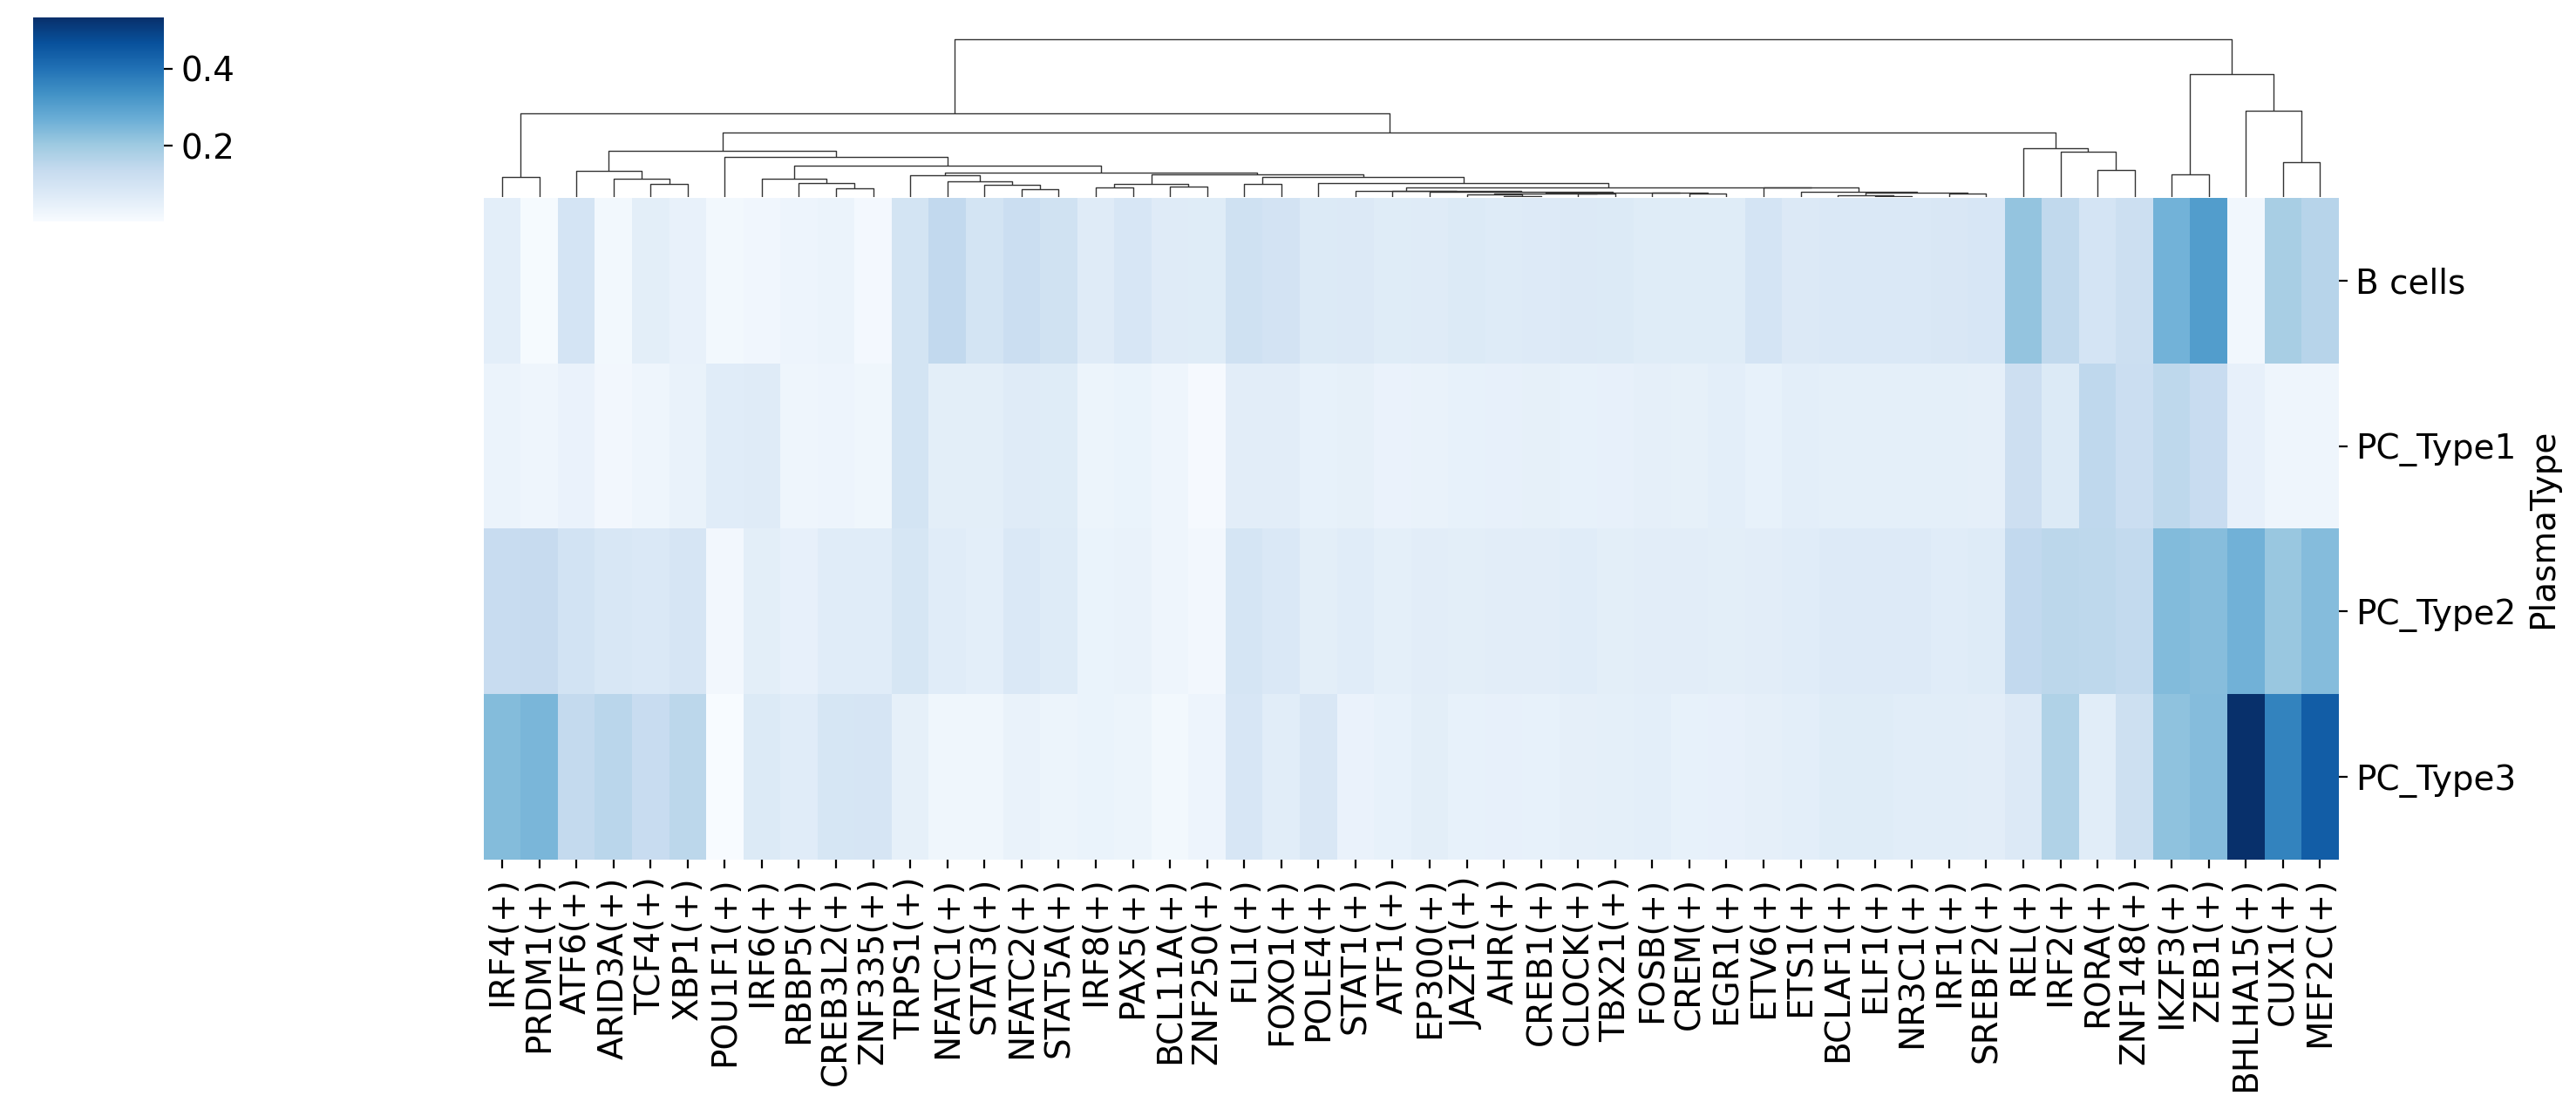

In [43]:
custom_order = ['B cells','PC_Type1', 'PC_Type2', 'PC_Type3' ] 

mean_auc_by_cell_type_top_n = mean_auc_by_cell_type_top_n.loc[custom_order]

g=sns.clustermap(
    mean_auc_by_cell_type_top_n,
    figsize=[15, 6.5],
    cmap="Blues",
    xticklabels=True,
    yticklabels=custom_order,  
    row_cluster=False, 
)
g.savefig("clustermap_output.pdf")

plt.show()


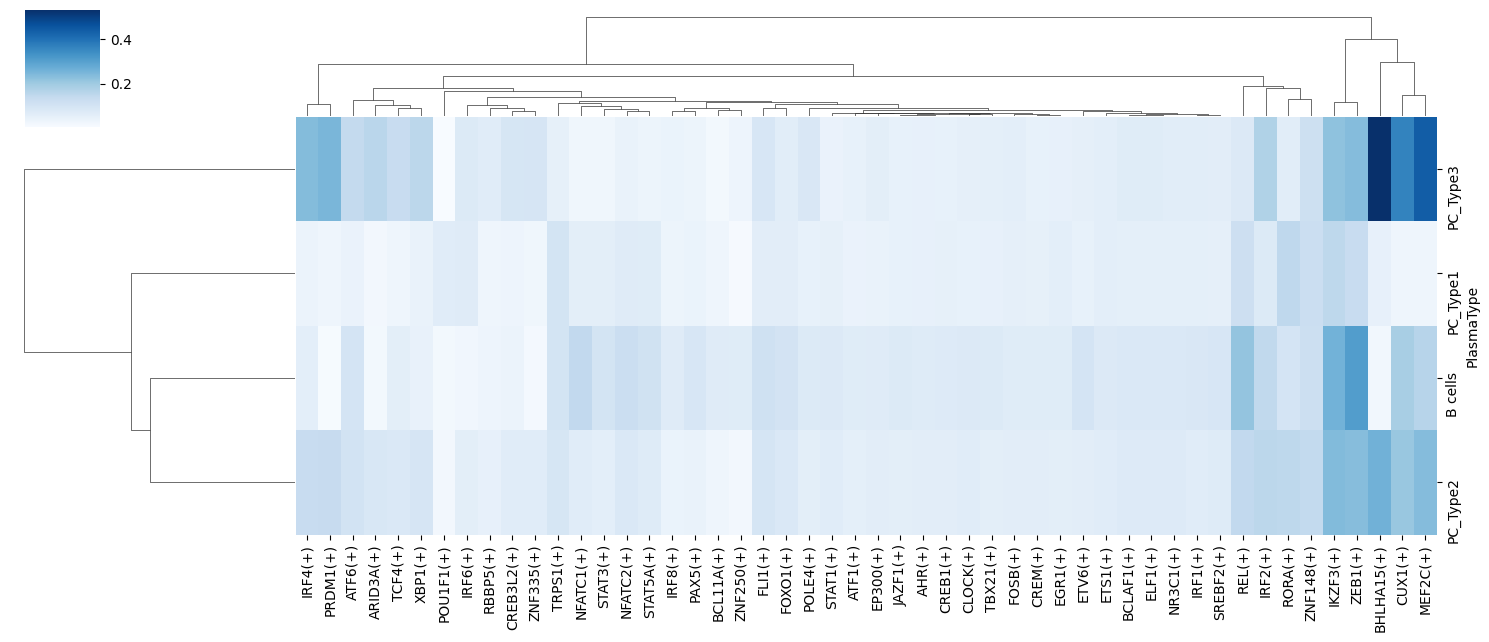

In [36]:
sns.clustermap(
    mean_auc_by_cell_type_top_n,
    figsize=[15, 6.5],
    cmap="Blues",
    xticklabels=True,
    yticklabels=True,
)

In [ ]:
tf_names = top_tfs.index.str.replace("\(\+\)", "")
adata_batch_top_tfs = adata[:, adata.var_names.isin(tf_names)]

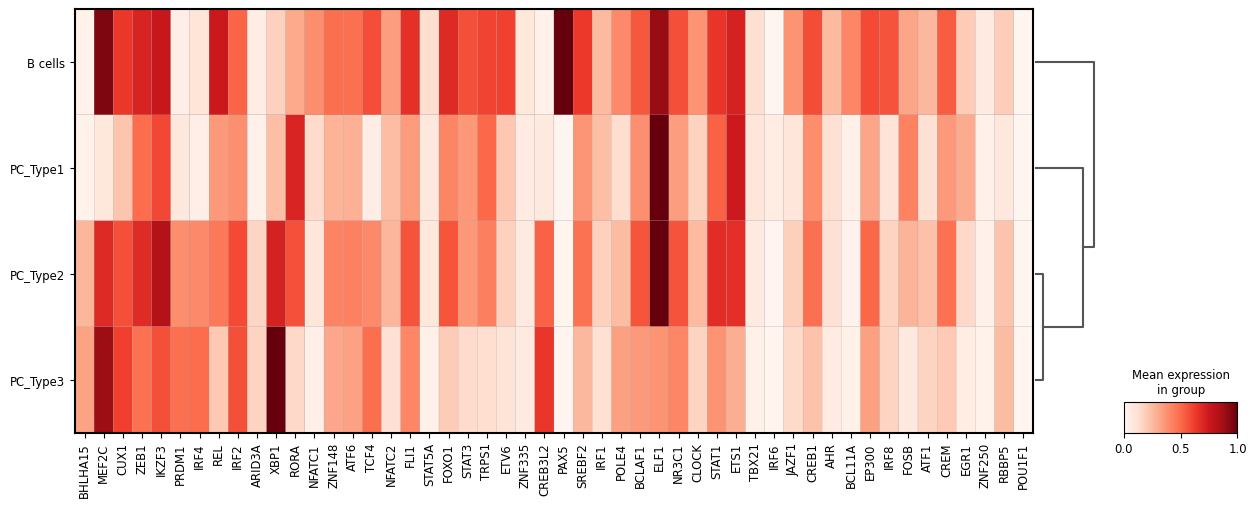

In [38]:
sc.pl.matrixplot(
    adata,
    tf_names,
    groupby="PlasmaType",
    cmap="Reds",
    dendrogram=True,
    figsize=[15, 5.5],
    standard_scale="group",
)

In [44]:
auc_mtx

,AHR(+),ARID3A(+),ARNT(+),ARNTL(+),ARNTL2(+),ATF1(+),ATF2(+),ATF3(+),ATF6(+),ATF6B(+),...,ZNF410(+),ZNF444(+),ZNF45(+),ZNF513(+),ZNF550(+),ZNF567(+),ZNF569(+),ZNF76(+),ZSCAN31(+),PlasmaType
AAACGAAAGGTCCCGT-1_DUR_JE,0.050368,0.043577,0.049814,0.071221,0.021362,0.045779,0.033885,0.049159,0.102485,0.023471,...,0.000000,0.000000,0.000000,0.023052,0.000000,0.0,0.012659,0.042009,0.006460,PC_Type1
AAAGAACCAGGCGATA-1_DUR_JE,0.026868,0.010153,0.025405,0.051730,0.018408,0.045499,0.044008,0.055176,0.023104,0.074720,...,0.000000,0.000000,0.000000,0.012920,0.199289,0.0,0.046031,0.003641,0.021964,PC_Type1
AAAGGTACAACCGTGC-1_DUR_JE,0.072753,0.017976,0.049446,0.090884,0.029162,0.070195,0.060067,0.077219,0.080521,0.032171,...,0.000000,0.000000,0.106866,0.028560,0.000000,0.0,0.005305,0.010336,0.029177,PC_Type2
AAAGTCCAGCACTCGC-1_DUR_JE,0.105180,0.006783,0.055060,0.091825,0.032232,0.052947,0.049870,0.073454,0.091883,0.000000,...,0.000000,0.082171,0.000000,0.000000,0.000000,0.0,0.027805,0.000000,0.000000,PC_Type1
AACAACCTCCGCAACG-1_DUR_JE,0.078400,0.010603,0.033543,0.094257,0.043597,0.056206,0.048500,0.069251,0.060306,0.033463,...,0.000000,0.000000,0.000000,0.003332,0.000000,0.0,0.013538,0.000000,0.006675,PC_Type1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCCTCGTCTAACGT-1_JH_JE,0.039494,0.162060,0.047828,0.033180,0.005255,0.037377,0.033103,0.040914,0.161613,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.018212,0.009240,0.037360,PC_Type3
TTTCGATCATCGATGT-1_JH_JE,0.038407,0.136530,0.055272,0.058691,0.009695,0.045285,0.032473,0.043756,0.129351,0.000000,...,0.000000,0.031977,0.000000,0.000000,0.100775,0.0,0.003862,0.002153,0.006568,PC_Type2
TTTCGATGTACGCTTA-1_JH_JE,0.053030,0.209232,0.043662,0.042322,0.018671,0.048577,0.034991,0.045155,0.206186,0.000000,...,0.000000,0.063372,0.088778,0.008840,0.000000,0.0,0.007312,0.000000,0.000000,PC_Type2
TTTGATCAGCTGGTGA-1_JH_JE,0.051494,0.044546,0.035983,0.061151,0.030308,0.037007,0.035770,0.052283,0.069083,0.000000,...,0.004594,0.000000,0.064046,0.000000,0.000000,0.0,0.011312,0.000000,0.023148,PC_Type2


In [49]:
mean_auc_by_cell_type
mean_auc_by_cell_type.to_csv('mean_auc_by_cell_type.csv')

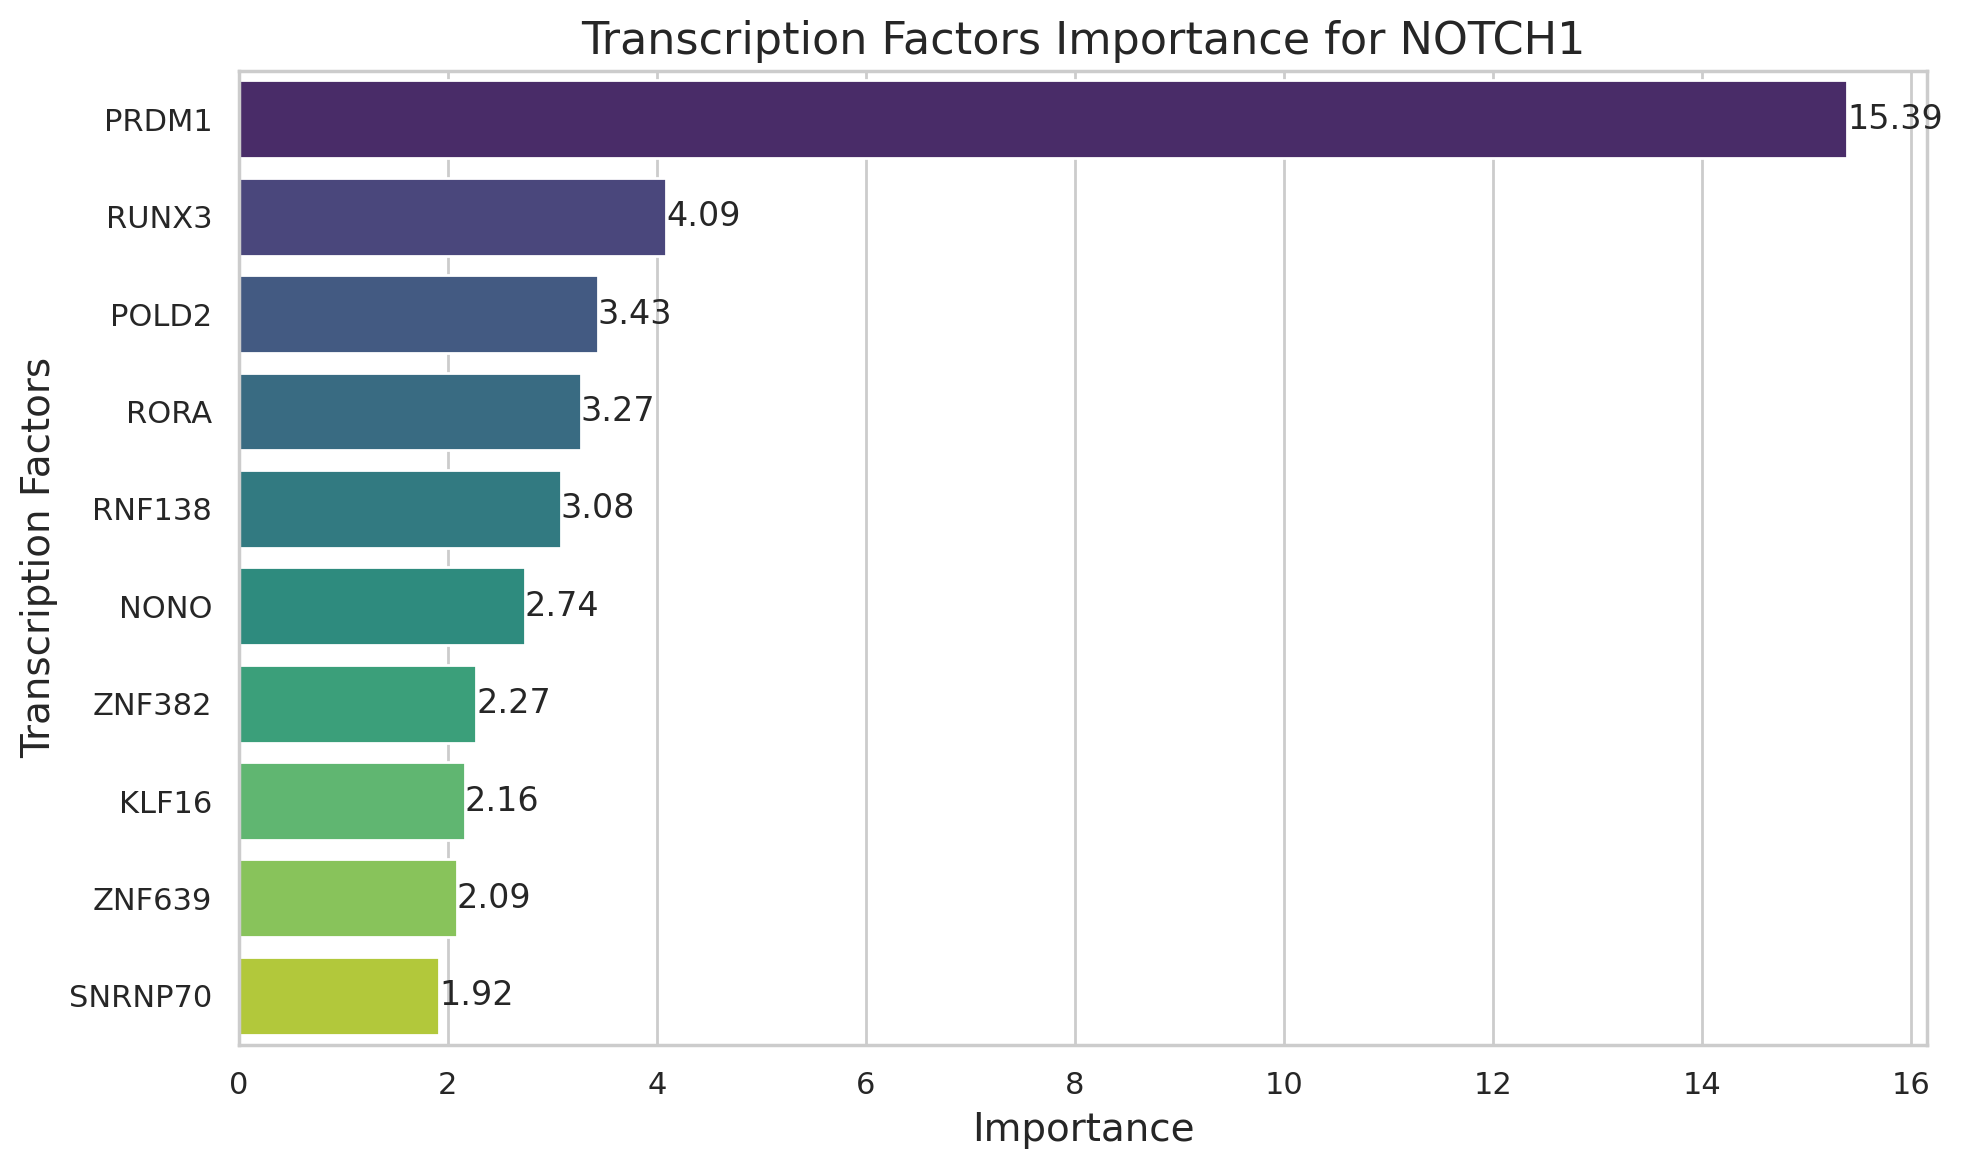

In [47]:
data = {
    "TF": ["PRDM1", "RUNX3", "POLD2", "RORA", "RNF138", "NONO", "ZNF382", "KLF16", "ZNF639", "SNRNP70"],
    "target": ["NOTCH1"] * 10,
    "importance": [15.38528409, 4.0898436, 3.43335814, 3.271093638, 3.078881253, 
                   2.73653751, 2.27202138, 2.163177843, 2.086015233, 1.917648879]
}

df = pd.DataFrame(data)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='importance', y='TF', data=df, palette='viridis')

plt.title('Transcription Factors Importance for NOTCH1', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Transcription Factors', fontsize=14)

for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_width():.2f}', 
                      (p.get_width(), p.get_y() + p.get_height() / 2), 
                      ha='left', va='center')
plt.tight_layout()
plt.savefig('tf_importance_notch1.pdf', format='pdf')

plt.show()
